# Задание №1

In [1]:
#Библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import requests
from urllib.parse import urlencode
import scipy.stats as stats
from scipy.stats import normaltest, levene

=== Информация о данных ===

Данные о регистрациях:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 3 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   reg_ts    1000000 non-null  int64 
 1   uid       1000000 non-null  int64 
 2   reg_date  1000000 non-null  object
dtypes: int64(2), object(1)
memory usage: 22.9+ MB
None

Минимальная дата регистрации: 1998-11-18
Максимальная дата регистрации: 2020-09-23

Данные об авторизациях:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   auth_ts    int64 
 1   uid        int64 
 2   auth_date  object
dtypes: int64(2), object(1)
memory usage: 219.7+ MB
None

Минимальная дата авторизации: 1998-11-18
Максимальная дата авторизации: 2020-09-23

=== Проверка дубликатов ===
Дубликатов в данных о регистрациях: 0
Дубликатов в данных об авторизациях: 

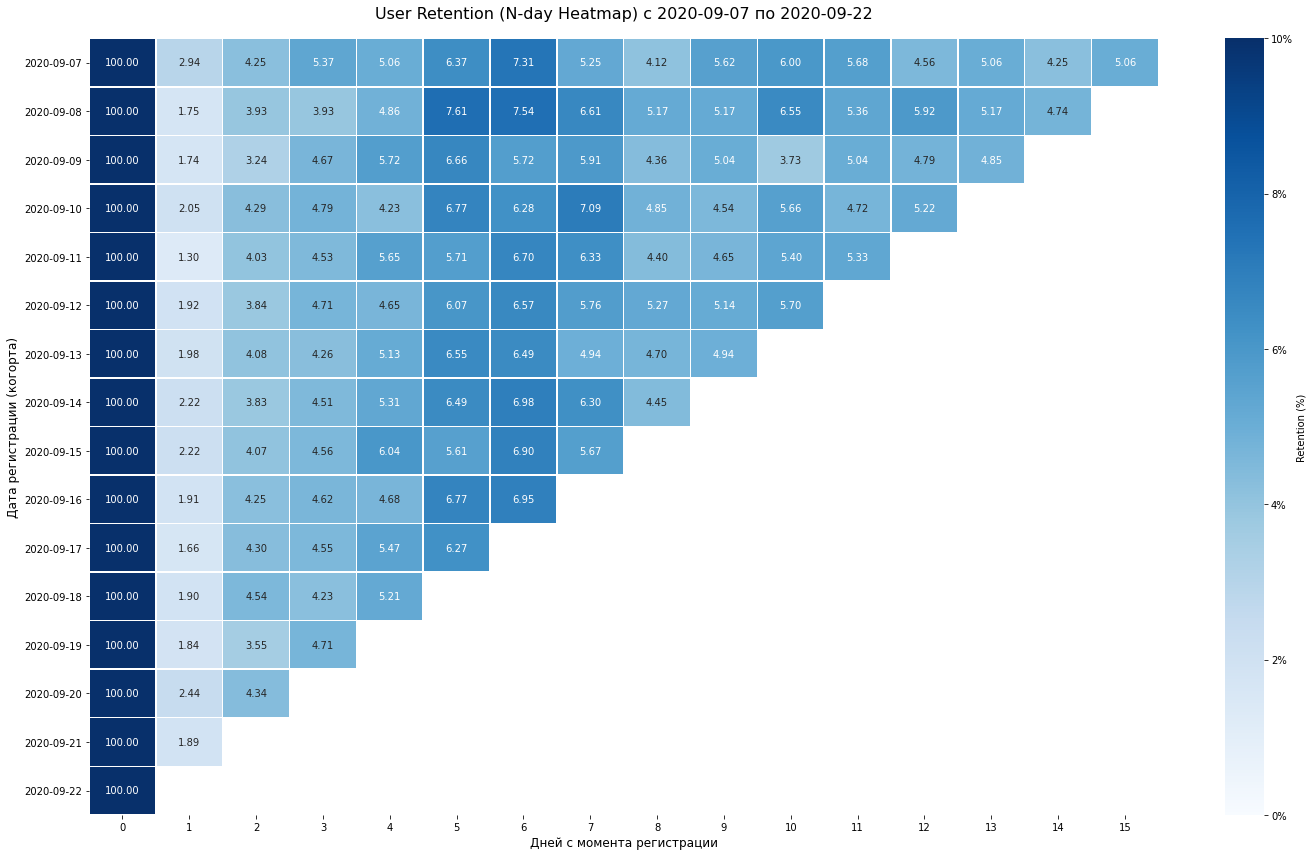

In [2]:

# Константы для путей к файлам
REG_DATA_PATH = '~/shared/problem1-reg_data.csv'
AUTH_DATA_PATH = '~/shared/problem1-auth_data.csv'



# Загрузка данных
reg = pd.read_csv(REG_DATA_PATH, sep=';')
auth = pd.read_csv(AUTH_DATA_PATH, sep=';')
  
# Преобразование timestamp в даты
reg['reg_date'] = pd.to_datetime(reg['reg_ts'], unit='s').dt.date
auth['auth_date'] = pd.to_datetime(auth['auth_ts'], unit='s').dt.date
   
# Проверка данных
print('=== Информация о данных ===')
print('\nДанные о регистрациях:')
print(reg.info())
print(f'\nМинимальная дата регистрации: {reg["reg_date"].min()}')
print(f'Максимальная дата регистрации: {reg["reg_date"].max()}')
    
print('\nДанные об авторизациях:')
print(auth.info())
print(f'\nМинимальная дата авторизации: {auth["auth_date"].min()}')
print(f'Максимальная дата авторизации: {auth["auth_date"].max()}')
    
# Проверка дубликатов
print('\n=== Проверка дубликатов ===')
print(f'Дубликатов в данных о регистрациях: {reg.duplicated().sum()}')
print(f'Дубликатов в данных об авторизациях: {auth.duplicated().sum()}')
    
# Объединение данных
merged = auth.merge(reg, on='uid', how='left')
merged = merged.drop(['auth_ts', 'reg_ts'], axis=1)

def display_retention_by_day(reg_data, auth_data, start_date, end_date, max_retention=10):
    """
    Параметры:
        reg_data (DataFrame): Данные о регистрациях
        auth_data (DataFrame): Данные об авторизациях
        start_date (str): Начальная дата периода (YYYY-MM-DD)
        end_date (str): Конечная дата периода (YYYY-MM-DD)
        max_retention (int): Максимальное значение retention для шкалы
    """
    # Фильтрация по дате
    start = pd.to_datetime(start_date).date()
    end = pd.to_datetime(end_date).date()
    
    reg_filtered = reg_data[(reg_data['reg_date'] >= start) & (reg_data['reg_date'] <= end)]
    auth_filtered = auth_data[(auth_data['auth_date'] >= start) & (auth_data['auth_date'] <= end)]
    
    # Объединение и очистка
    merged = auth_filtered.merge(reg_filtered, on='uid', how='left')
    merged = merged.dropna(subset=['reg_date'])
    
    # Расчет дней с момента регистрации
    merged['days_since_reg'] = (pd.to_datetime(merged['auth_date']) - 
                               pd.to_datetime(merged['reg_date'])).dt.days
    
    # Группировка и расчет retention
    cohorts = (merged.groupby(['reg_date', 'days_since_reg'])['uid']
              .nunique()
              .reset_index(name='user_count'))
    
    pivot = cohorts.pivot(index='reg_date', columns='days_since_reg', values='user_count')
    retention = pivot.divide(pivot[0], axis=0)
    retention_percent = (retention * 100).round(2)
    
#     # Настройка цветовой схемы
#     colors = ["#89CFF0", "#B0E0E6", "#E6F8B2", "#FFFACD", "#FDFF96"]
#     cmap = LinearSegmentedColormap.from_list("retention_cmap", colors)
    
    # Визуализация
    plt.figure(figsize=(20, 12))
    heatmap = sns.heatmap(
        retention_percent,
        cmap='Blues',
        annot=True, 
        fmt=".2f",
        linewidths=0.5,
        #linecolor='gray',
        vmin=0,
        vmax=max_retention,
        cbar_kws={'label': 'Retention (%)'}
    )
    
    # Настройка оформления
    plt.title(f"User Retention (N-day Heatmap) с {start_date} по {end_date}", 
              fontsize=16, pad=20)
    plt.ylabel("Дата регистрации (когорта)", fontsize=12)
    plt.xlabel("Дней с момента регистрации", fontsize=12)
    
    # Настройка цветовой шкалы
    cbar = heatmap.collections[0].colorbar
    cbar.set_ticks(range(0, max_retention+1, 2))
    cbar.set_ticklabels([f"{x}%" for x in range(0, max_retention+1, 2)])
    
    plt.tight_layout()
    plt.show()

# Основная функция для анализа
def main():
    
    # Анализ retention
    print('\n=== Анализ Retention ===')
    display_retention_by_day(reg, auth, "2020-09-07", "2020-09-22")

main()

# Задание №2


In [3]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q' 

# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

# Загружаем файл и сохраняем его
download_response = requests.get(download_url)
dt = pd.read_csv(download_url, sep=';')

# Проверка данных
print('=== Информация о данных ===')
print(f'\nДанные о регистрациях: \n{dt.info()}')
print(f'\nКоличество строк и столбцов: {dt.shape}')
print(f'\nДубликатов в данных о регистрациях: {dt.duplicated().sum()}')
print(f'\nПропущенных значений: \n{dt.isna().sum()}')
print(f'\nКоличество уникальных значений: \n{dt.nunique()}')
print(f'\nНас интересуеют user_id, количество: {dt.user_id.nunique()}')
print(f'\nПодсчет пользователей по группам: \n{dt.testgroup.value_counts()}')

#Разделение на группы 
group_a = dt[dt['testgroup'] == 'a']
group_b = dt[dt['testgroup'] == 'b']
cont = group_a
test = group_b
print(f'\nОбщая сумма дохода по каждой группе: \n{dt.groupby("testgroup", as_index=False)["revenue"].sum()}')
print('\n=== Сводная статистика по группе А (контрольная)===')
print(cont.revenue.describe())
print(f'\n=== Сводная статистика по группе Б (тестовая)===')
print(test.revenue.describe())
print(f'\nРазница между контрольной и тестовой группой: {abs(cont.testgroup.count()-test.testgroup.count())}')



=== Информация о данных ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB

Данные о регистрациях: 
None

Количество строк и столбцов: (404770, 3)

Дубликатов в данных о регистрациях: 0

Пропущенных значений: 
user_id      0
revenue      0
testgroup    0
dtype: int64

Количество уникальных значений: 
user_id      404770
revenue        1477
testgroup         2
dtype: int64

Нас интересуеют user_id, количество: 404770

Подсчет пользователей по группам: 
b    202667
a    202103
Name: testgroup, dtype: int64

Общая сумма дохода по каждой группе: 
  testgroup  revenue
0         a  5136189
1         b  5421603

=== Сводная статистика по группе А (контрольная)===
count    202103.000000

Количество записей в тестовой группе и контрольной ± одинаково, это позволит провести корректный анализ.


Среднее значение дохода в тестовой группе выше, чем в контрольной. Это может указывать на то, что тестовая группа имеет более высокие доходы в среднем.


 Стандартное отклонение в контрольной группе значительно выше, чем в тестовой. Это говорит о том, что значения дохода в контрольной группе более разбросаны. В тестовой группе доходы более сгруппированы вокруг среднего значения.


В контрольной группе максимальное значение дохода значительно выше, чем в тестовой. Это может указывать на наличие нескольких очень высоких значений (возможно, выбросов) в контрольной группе, которые увеличивают среднее и стандартное отклонение.

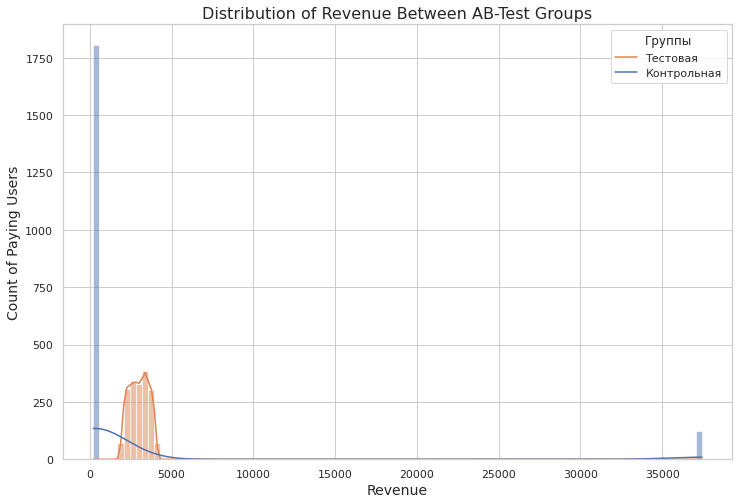

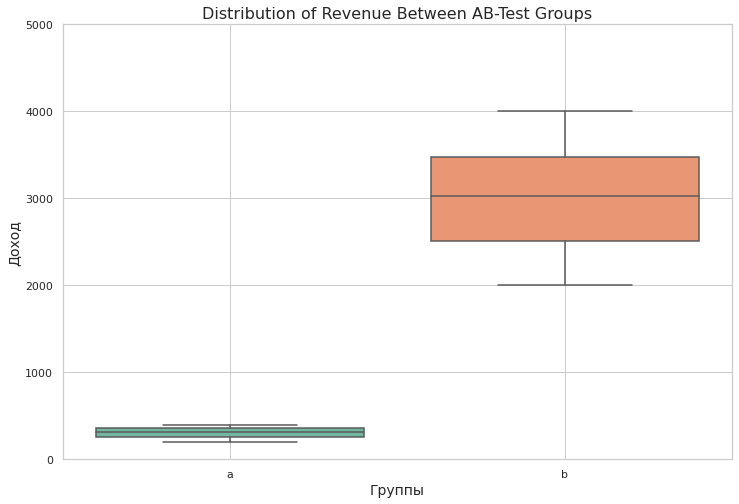


Количество анамално больших чеков: 123

Контрольная группа - NormaltestResult(statistic=585152.7312728433, pvalue=0.0)
Тестовая группа - NormaltestResult(statistic=326622.39540856465, pvalue=0.0)


In [4]:
#Гистограмма
sns.set(style='whitegrid')
plt.figure(figsize=(12, 8))
sns.histplot(data=dt[dt['revenue'] > 0], 
             x='revenue', 
             hue='testgroup', 
             kde=True, 
             bins=100,   
             #alpha=0.7,  
             stat='count')  

plt.title('Distribution of Revenue Between AB-Test Groups', fontsize=16)
plt.xlabel('Revenue', fontsize=14)
plt.ylabel('Count of Paying Users', fontsize=14)
plt.legend(title='Группы', labels=['Тестовая' ,'Контрольная' ], loc='upper right')
plt.grid(True)
plt.show()


#Усатый ящик
sns.set(style='whitegrid')
plt.figure(figsize=(12, 8))
sns.boxplot(data=dt[dt['revenue'] > 0], 
            x='testgroup', 
            y='revenue', 
            palette='Set2')
plt.title('Distribution of Revenue Between AB-Test Groups', fontsize=16)
plt.xlabel('Группы', fontsize=14)
plt.ylabel('Доход', fontsize=14)
plt.ylim(0, 5000) #Установка пределов по У
plt.grid(True)
plt.show()

print(f'\nКоличество анамално больших чеков: {dt[dt["revenue"] >= 35000]["user_id"].nunique()}\n')

print(f"Контрольная группа - {normaltest(cont['revenue'])}")
print(f"Тестовая группа - {normaltest(test['revenue'])}")

# а- контрольная группа
# б- тестовая группа

Распределение в контрольной групе не похоже на нормальное, имеются выбросы (revenuu> 35'000), значение по доходности лаколезовоно около ±1'000

Распределение в тестовой групе похоже на нормальное, посел проверки на нормальнось, выяснилось, что обе группы не нормальные


    
Метрики которые будем использовать для проверки гипотез:

- CR - конверсия, процент полдьзователей совершивших покупку (число платящих пользователей/число пользователей * 100)
- ARPU - средний доход на пользователя (выручка/число пользователей)
- ARPPU - средние траты каждого платящего пользователя (выручка/число платящих пользователей)

In [5]:
 # Расчет основных показателей
paying_control = (cont["revenue"] > 0).sum()
paying_test = (test["revenue"] > 0).sum()
    
n_control = len(cont)
n_test = len(test)
    
revenue_control = cont["revenue"].sum()
revenue_test = test["revenue"].sum()
    
cr_control = paying_control / n_control if n_control > 0 else 0
cr_test = paying_test / n_test if n_test > 0 else 0
    
arpu_control = revenue_control / n_control if n_control > 0 else 0
arpu_test = revenue_test / n_test if n_test > 0 else 0
    
arppu_control = revenue_control / paying_control if paying_control > 0 else 0
arppu_test = revenue_test / paying_test if paying_test > 0 else 0
    
print("\n=== Результаты A/B теста ===")
print(f"{'Метрика':<25} {'Контроль':<15} {'Тест':<15}")
print("-" * 55)
print(f"{'Количество пользователей':<25} {n_control:<15} {n_test:<15}")
print(f"{'Количество платящих':<25} {paying_control:<15} {paying_test:<15}")
print(f"{'Выручка по группам':<25} {revenue_control:<15.2f} {revenue_test:<15.2f}")
print(f"\n{'Конверсия (CR)':<25} {cr_control:<15.4f} {cr_test:<15.4f}")
print(f"{'ARPU':<25} {arpu_control:<15.2f} {arpu_test:<15.2f}")
print(f"{'ARPPU':<25} {arppu_control:<15.2f} {arppu_test:<15.2f}")
    



=== Результаты A/B теста ===
Метрика                   Контроль        Тест           
-------------------------------------------------------
Количество пользователей  202103          202667         
Количество платящих       1928            1805           
Выручка по группам        5136189.00      5421603.00     

Конверсия (CR)            0.0095          0.0089         
ARPU                      25.41           26.75          
ARPPU                     2664.00         3003.66        


ARPU и ARPPU в тестовой группе выше, при этотм CR в контрольной группе выше. 



Гипотезы:
- H0 различия в между тестовой и контрольной группой не являются статистически значимыми (или различий нет)
- H1 различия в между тестовой и контрольной группой являются статистически значимыми.




In [6]:

# 1. T-тест для сравнения ARPU между группами
arpu_t_stat, arpu_p_value = stats.ttest_ind(
    cont['revenue'], 
    test['revenue'], 
    equal_var=False  # Учитываем неравные дисперсии
)
print(f"Сравнение ARPU (доход на пользователя):")
print(f"t-статистика = {arpu_t_stat:.2f}, p-value = {arpu_p_value:.4f}")
print("Вывод:", "Есть значимые различия" if arpu_p_value < 0.05 else "Нет значимых различий")
print()

# 2. T-тест для сравнения ARPPU между группами
arppu_a = cont[cont['revenue'] > 0]['revenue']
arppu_b = test[test['revenue'] > 0]['revenue']

arppu_t_stat, arppu_p_value = stats.ttest_ind(
    arppu_a,
    arppu_b,
    equal_var=False
)
print(f"Сравнение ARPPU (доход на платящего пользователя):")
print(f"t-статистика = {arppu_t_stat:.2f}, p-value = {arppu_p_value:.4f}")
print("Вывод:", "Есть значимые различия" if arppu_p_value < 0.05 else "Нет значимых различий")
print()

# 3. Хи-квадрат тест для сравнения конверсии (CR)
contingency_table = pd.crosstab(
    pd.concat([cont['testgroup'], test['testgroup']]),  
    pd.concat([cont['revenue'] > 0, test['revenue'] > 0])  
)

chi2_stat, chi2_p_value, _, _ = stats.chi2_contingency(contingency_table)
print(f"Сравнение CR (конверсии в покупку):")
print(f"Хи-квадрат = {chi2_stat:.2f}, p-value = {chi2_p_value:.4f}")
print("Вывод:", "Есть значимые различия" if chi2_p_value < 0.05 else "Нет значимых различий")

Сравнение ARPU (доход на пользователя):
t-статистика = -0.62, p-value = 0.5330
Вывод: Нет значимых различий

Сравнение ARPPU (доход на платящего пользователя):
t-статистика = -1.64, p-value = 0.1002
Вывод: Нет значимых различий

Сравнение CR (конверсии в покупку):
Хи-квадрат = 4.37, p-value = 0.0365
Вывод: Есть значимые различия


Результаты теста носят неоднозначный характер: в то время как конверсия выше в контрольной группе, различия в доходности между группами статистически не подтверждены. Это свидетельствует о том, что тестируемые изменения не приводят к улучшению. Применять на всех пользователей не стоит.

# Задание №3

Метрики которые могут быть интересны: 

- DAU- отслеживать количество пользователей в день в зависимости от события
- MAU- посмотреть привлекли мы новых пользователей или вернули старых, кто не заходил давно 
- Средняя выручка активных пользователей, чтобы посмотреть на сколько то или иное событие монетезируется
- Средлний доход на платящего пользователя 
- LTV- посмотреть как событие влияет на вовлеченность и монетезацию
- Выручка от события
- Доля игроков, завершивших событие – процент игроков, дошедших до конца всех уровней и получивших награду.

При изменениимеханики события :


- Среднее количество повторных прохождений уровней - сколько раз игроки переигрывают одни и те же уровни
- Коэффициент откатов на игрока - среднее число возвратов на предыдущие уровни
- Retention (1/3/7 дней) - динамика возвращаемости после старта события
- Пиковая вовлеченность - максимальное время, которое игроки проводят в событии за одну сессию
- Процент досрочных выходов - игроки, бросившие событие до завершения
- Среднее количество покупок на "застрявшего" игрока - как часто испытывающие трудности платят
- На каком уровне чаще всего выходят из игры
- Количество или доля покупок, сделанных сразу после неудачи
